# Protein Fold Identification and Classification

#### Overview
In this project, we will be trying to create a neural network architecture capable of classifying protein organelle localization labels. We will be dealing with the input of the proposed neural network as three-dimensional (each dimension represents colors (red filter, blue filter, yellow filter, green filter)), and the input to the neural network (samples, 2, 90, 90, 3) represents the number 2 in the proposed structure (RGB image, image with yellow filter).

In [2]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt
import pathlib as p
import os
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
from keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Exploratory Data Analysis

There are in total 28 different labels present in the dataset and comprises of 27 different cell types of highly different morphology, which affect the protein patterns of the different organelles. All image samples are represented by four filters (stored as individual files), the protein of interest (green) plus three cellular landmarks: nucleus (blue), microtubules (red), endoplasmic reticulum (yellow). The green filter should hence be used to predict the label, and the other filters are used as references.

In [3]:
#Directories
os.listdir('../input/human-protein-atlas-image-classification/')

['sample_submission.csv', 'train.csv', 'test', 'train']

In [4]:
# lets see how many images are in the training and test dataset
print("Number of Images Training Dataset:",len(os.listdir('../input/human-protein-atlas-image-classification/train')))
print("Number of Images Test Dataset:",len(os.listdir('../input/human-protein-atlas-image-classification/test')))

Number of Images Training Dataset: 124288
Number of Images Test Dataset: 46808


In [5]:
# loading the labels
train_data = pd.read_csv('../input/human-protein-atlas-image-classification/train.csv')
sample_submission = pd.read_csv('../input/human-protein-atlas-image-classification/sample_submission.csv')
test_path = '../input/human-protein-atlas-image-classification/test/'
train_path = '../input/human-protein-atlas-image-classification/train/'
test_data = pd.DataFrame({'id':os.listdir(test_path)})

print(train_data.shape)

(31072, 2)


In [6]:
train_data.sample(10)

,Id,Target
19215,9ebf50dc-bbab-11e8-b2ba-ac1f6b6435d0,18 5
2953,18ae8944-bbb1-11e8-b2ba-ac1f6b6435d0,2 0
126,0115f496-bbb8-11e8-b2ba-ac1f6b6435d0,2
4079,21eab8de-bbb1-11e8-b2ba-ac1f6b6435d0,2
12147,64bfd292-bbbc-11e8-b2ba-ac1f6b6435d0,21
28482,eaa80446-bb9f-11e8-b2b9-ac1f6b6435d0,3
6203,339a7858-bbbb-11e8-b2ba-ac1f6b6435d0,6
25722,d3dcc7ee-bbac-11e8-b2ba-ac1f6b6435d0,22 0
25160,cf585912-bbb2-11e8-b2ba-ac1f6b6435d0,12 0
25650,d34a0006-bb9a-11e8-b2b9-ac1f6b6435d0,3


In [7]:
test_data.sample(10)

,id
43967,ee238416-bacc-11e8-b2b8-ac1f6b6435d0_red.png
12969,ea698244-bacc-11e8-b2b8-ac1f6b6435d0_blue.png
18610,d1096974-baca-11e8-b2b8-ac1f6b6435d0_green.png
12091,eae7bc18-bac7-11e8-b2b7-ac1f6b6435d0_yellow.png
7849,a9211684-bad7-11e8-b2b9-ac1f6b6435d0_green.png
31926,e3e92da4-bacf-11e8-b2b8-ac1f6b6435d0_blue.png
15282,2ca054f2-bac9-11e8-b2b8-ac1f6b6435d0_blue.png
20404,f744241c-bacf-11e8-b2b8-ac1f6b6435d0_red.png
26184,2613a980-bad9-11e8-b2b9-ac1f6b6435d0_red.png
30964,c0b1bf1a-bad7-11e8-b2b9-ac1f6b6435d0_green.png


In [8]:
df = train_data
df["complete_path"] = train_path + df["Id"]
df.head(5)

,Id,Target,complete_path
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,../input/human-protein-atlas-image-classificat...
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,../input/human-protein-atlas-image-classificat...
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,../input/human-protein-atlas-image-classificat...
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,../input/human-protein-atlas-image-classificat...
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,../input/human-protein-atlas-image-classificat...


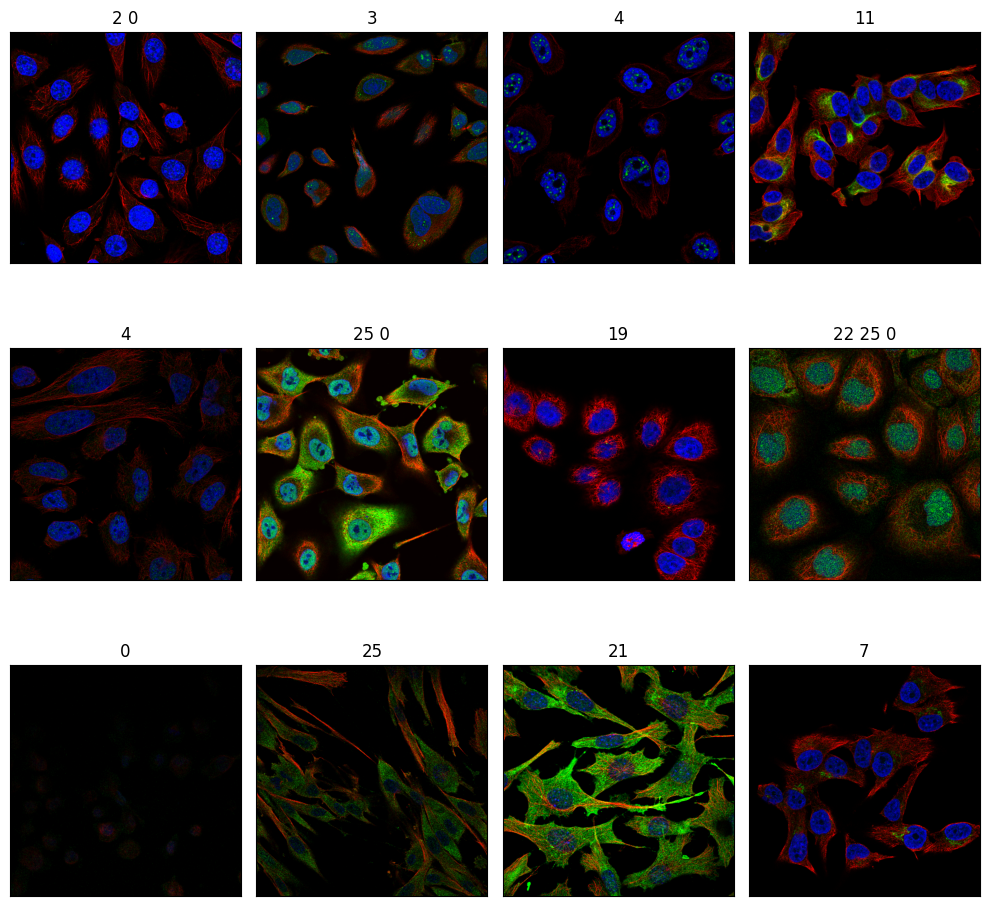

In [9]:
# let's look at some images
import random
fig, axes = plt.subplots(3, 4, figsize=(10, 10))
for i in range(3):
    for j in range(4):
        idx = random.randint(0, df.shape[0])
        row = df.iloc[idx,:]
        path = row.complete_path
        red = np.array(Image.open(path + '_red.png'))
        green = np.array(Image.open(path + '_green.png'))
        blue = np.array(Image.open(path + '_blue.png'))
        im = np.stack((
                red,
                green,
                blue),-1)
        axes[i][j].imshow(im)
        axes[i][j].set_title(row.Target)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
fig.tight_layout()
fig.show(5);

### Data Preprocessing

Now that we've gotten a general sense of the shape and composition of the data, let's split the dataset and clean it.

In [10]:
# split the dataset
train, validation = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
print(f'Shape of train: {train.shape}')
print(f'Shape of val: {validation.shape}')

Shape of train: (24857, 3)
Shape of val: (6215, 3)


In [12]:
# now let's clean the data
def get_clean_data(df1):
    targets = []
    paths = []
    for _, row in df1.iterrows():
        target_np = np.zeros((28))
        t = [int(t) for t in row.Target.split()]
        target_np[t] = 1
        targets.append(target_np)
        paths.append(row.complete_path)
    return np.array(paths), np.array(targets)

In [13]:
train_path, train_target = get_clean_data(train)
val_path, val_target = get_clean_data(validation)

In [14]:
# create the training and validation datasets
train_data = tf.data.Dataset.from_tensor_slices((train_path, train_target))
val_data = tf.data.Dataset.from_tensor_slices((val_path, val_target))

In [15]:
def load_data(path, target):
    red = tf.squeeze(tf.image.decode_png(tf.io.read_file(path+'_red.png'), channels=1), [2])
    blue = tf.squeeze(tf.image.decode_png(tf.io.read_file(path+'_blue.png'), channels=1), [2])
    green = tf.squeeze(tf.image.decode_png(tf.io.read_file(path+'_green.png'), channels=1), [2])
    yellow=tf.squeeze(tf.image.decode_png(tf.io.read_file(path+'_yellow.png'), channels=1), [2])
    img = tf.stack((
                red,
                green,
                blue), axis=2)
    return img, target

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.map(load_data, num_parallel_calls=AUTOTUNE)
val_data = val_data.map(load_data, num_parallel_calls=AUTOTUNE)

In [16]:
# adjust image(s) contrast

def image_augment(img, target):
    img = tf.image.random_contrast(img, lower=0.3, upper=2.0)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    return img, target
    
train_data = train_data.map(image_augment, num_parallel_calls=AUTOTUNE)

In [17]:
input_shape = (512, 512, 3)
batch_size = 16

train_data_batches = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_data_batches = val_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### Model Architecture

This architecture is a modified version of the ResNet50 model pre-trained on ImageNet data, followed by additional layers for multi-label classification with 28 classes. We first initializes the model with pre-trained weights on ImageNet. Then we flatten the output from the ResNet50 convolutional layers into a single vector, apply dropout regularization to prevent overfitting, and then we add a densely connected layer with ReLU activation. The final output layer with 28 units and a sigmoid activation function where each output neuron represents a class and outputs a probability between 0 and 1.

In [18]:
resnet_model = applications.ResNet50(include_top=False, weights='imagenet')

resnet_model.trainable = True

input_layer = Input(shape=input_shape)
x = resnet_model(input_layer)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(28, activation='sigmoid')(x)
model = Model(input_layer, output)

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dropout (Dropout)           (None, 524288)            0         
                                                                 
 dense (Dense)               (None, 512)               268435968 
                                                                 
 dropout_1 (Dropout)         (None, 512)               0      

In [19]:
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [20]:
history = model.fit(train_data_batches, steps_per_epoch = 150, 
                    validation_data = val_data_batches, epochs=10)

Epoch 1/10
150/150 [==============================] - 167s 816ms/step - loss: 0.4175 - binary_accuracy: 0.9256 - val_loss: 0.7888 - val_binary_accuracy: 0.9375
Epoch 2/10
150/150 [==============================] - 113s 754ms/step - loss: 0.2006 - binary_accuracy: 0.9388 - val_loss: 0.1813 - val_binary_accuracy: 0.9465
Epoch 3/10
150/150 [==============================] - 113s 755ms/step - loss: 0.1859 - binary_accuracy: 0.9438 - val_loss: 0.2012 - val_binary_accuracy: 0.9472
Epoch 4/10
150/150 [==============================] - 113s 753ms/step - loss: 0.1799 - binary_accuracy: 0.9446 - val_loss: 0.1681 - val_binary_accuracy: 0.9473
Epoch 5/10
150/150 [==============================] - 113s 753ms/step - loss: 0.1777 - binary_accuracy: 0.9454 - val_loss: 0.4063 - val_binary_accuracy: 0.9458
Epoch 6/10
150/150 [==============================] - 113s 754ms/step - loss: 0.1798 - binary_accuracy: 0.9450 - val_loss: 0.1644 - val_binary_accuracy: 0.9482
Epoch 7/10
150/150 [====================

### Results

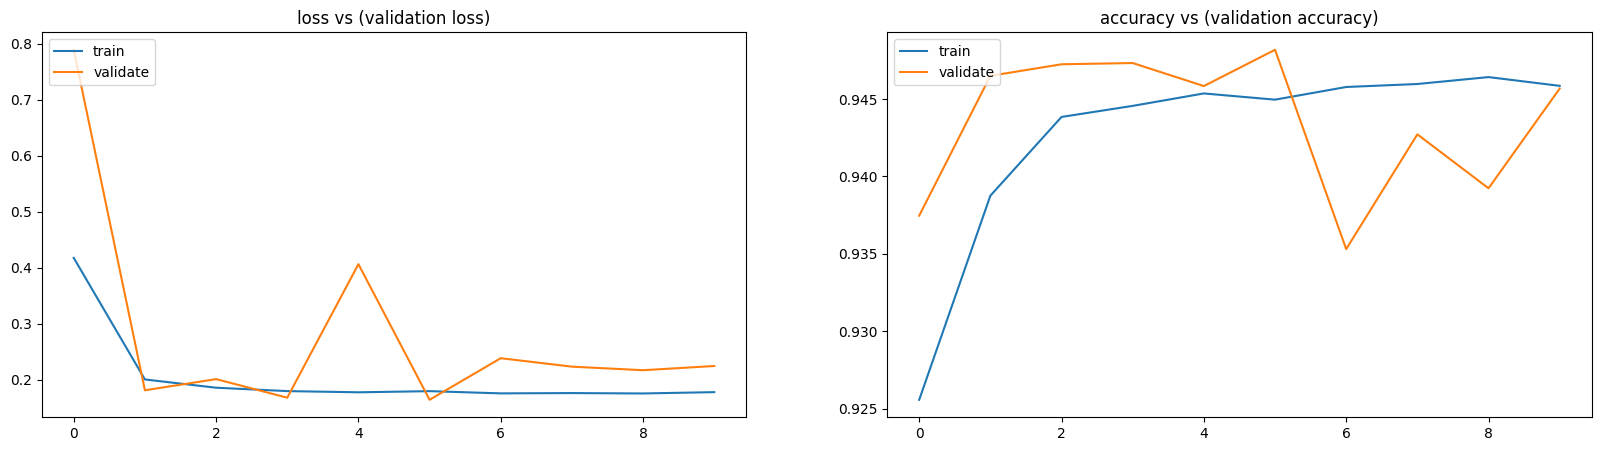

In [26]:
figures = ['loss', "binary_accuracy"]
titles = ["loss vs (validation loss)", "accuracy vs (validation accuracy)"] 
plt.figure(figsize = (20, 5))
for i in range(2):
    plt.subplot(1, 2, (i + 1))
    plt.title(titles[i])
    plt.plot(history.history[figures[i]])
    plt.plot(history.history['val_{}'.format(figures[i])])
    plt.legend(['train', 'validate'], loc='upper left')
plt.show()

### Conclusion

In conclusion, the developed neural network architecture exhibits promising performance in classifying protein organelle localization labels using three-dimensional RGB images with a yellow filter. Across 10 epochs and 150 steps per epoch, the model demonstrated robust learning, steadily improving both training and validation accuracies. With a final accuracy of 94% for both training and validation sets, accompanied by decreasing loss over time, the results signify the effectiveness and reliability of the model in accurately categorizing protein organelle localizations. This suggests its potential for practical deployment in biological research and analysis, showcasing its proficiency in handling complex spatial data for classification purposes.